In [ ]:
workers = 2
batch_size=50
nz = 100
n_epoch = 40
lr = 0.0002
beta1 = 0.5
outf = './result-GAN'
display_interval = 600

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Lambda(lambda x: x.view(-1))])
mnist_train = MNIST("MNIST",train=True, download=True, transform=transform)

dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

cuda:0


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=100):
        """
        :param nz: 入力ベクトルzの次元
        :param nch_g: 最終層の入力チャネル数
        :param nch: 出力画像のチャネル数
        """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(nz, 256),                      
                nn.ReLU(),                          
                nn.Linear(256, 512),
                nn.ReLU(),
                nn.Linear(512, 28*28),
                nn.Tanh()
        )

    def forward(self, z):
        return self.layers(z)
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(28*28, 384),   
                nn.ReLU(),
                nn.Linear(384, 128),
                nn.ReLU(),
                nn.Linear(128, 1),
                nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, device=device)

netG = Generator(nz=nz).to(device)
netD = Discriminator().to(device)


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [ ]:
G_losses = []
D_losses = []
D_x_out = []
D_G_z1_out = []

# 学習のループ
for epoch in range(n_epoch):
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)
        sample_size = real_image.size(0)
        
        # 標準正規分布からノイズを生成
        noise = torch.randn(sample_size, nz, device=device)
        # 本物画像に対する識別信号の目標値「1」
        real_target = torch.full((sample_size,), 1., device=device)
        # 生成画像に対する識別信号の目標値「0」
        fake_target = torch.full((sample_size,), 0., device=device) 
        
        ############################
        # 識別器Dの更新
        ###########################
        netD.zero_grad()    # 勾配の初期化

        output = netD(real_image)   # 識別器Dで本物画像に対する識別信号を出力
        errD_real = criterion(output.squeeze(), real_target)  # 本物画像に対する識別信号の損失値
        D_x = output.mean().item()  # 本物画像の識別信号の平均

        fake_image = netG(noise)    # 生成器Gでノイズから生成画像を生成
        
        output = netD(fake_image.detach())  # 識別器Dで本物画像に対する識別信号を出力
        errD_fake = criterion(output.squeeze(), fake_target)  # 生成画像に対する識別信号の損失値
        D_G_z1 = output.mean().item()  # 生成画像の識別信号の平均

        errD = errD_real + errD_fake    # 識別器Dの全体の損失
        errD.backward()    # 誤差逆伝播
        optimizerD.step()   # Dのパラメーターを更新

        ############################
        # 生成器Gの更新
        ###########################
        netG.zero_grad()    # 勾配の初期化
        
        output = netD(fake_image)   # 更新した識別器Dで改めて生成画像に対する識別信号を出力
        errG = criterion(output.squeeze(), real_target)   # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は「1」
        errG.backward()     # 誤差逆伝播
        D_G_z2 = output.mean().item()  # 更新した識別器Dによる生成画像の識別信号の平均

        optimizerG.step()   # Gのパラメータを更新

        if itr % display_interval == 0: 
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
                  .format(epoch + 1, n_epoch,
                          itr + 1, len(dataloader),
                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if epoch == 0 and itr == 0:     # 初回に本物画像を保存する
            vutils.save_image(real_image.reshape(batch_size, 1, 28, 28), '{}/real_samples.png'.format(outf),
                              normalize=True, nrow=10)

        # ログ出力用データの保存
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        D_x_out.append(D_x)
        D_G_z1_out.append(D_G_z1)

    ############################
    # 確認用画像の生成
    ############################
    fake_image = netG(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
    fake_image = fake_image.reshape(batch_size, 1, 28, 28)
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
                      normalize=True, nrow=10)


[1/40][1/469] Loss_D: 1.430 Loss_G: 0.678 D(x): 0.488 D(G(z)): 0.509/0.508
[2/40][1/469] Loss_D: 0.728 Loss_G: 1.970 D(x): 0.843 D(G(z)): 0.419/0.141
[3/40][1/469] Loss_D: 0.467 Loss_G: 2.023 D(x): 0.788 D(G(z)): 0.152/0.136
[4/40][1/469] Loss_D: 0.462 Loss_G: 1.917 D(x): 0.804 D(G(z)): 0.130/0.168
[5/40][1/469] Loss_D: 0.287 Loss_G: 4.048 D(x): 0.943 D(G(z)): 0.181/0.020
[6/40][1/469] Loss_D: 0.295 Loss_G: 3.037 D(x): 0.883 D(G(z)): 0.102/0.054
[7/40][1/469] Loss_D: 0.267 Loss_G: 3.618 D(x): 0.933 D(G(z)): 0.135/0.042
[8/40][1/469] Loss_D: 0.359 Loss_G: 3.061 D(x): 0.887 D(G(z)): 0.137/0.066
[9/40][1/469] Loss_D: 0.391 Loss_G: 4.058 D(x): 0.916 D(G(z)): 0.211/0.030
[10/40][1/469] Loss_D: 0.781 Loss_G: 5.397 D(x): 0.950 D(G(z)): 0.421/0.007
[11/40][1/469] Loss_D: 0.566 Loss_G: 2.146 D(x): 0.765 D(G(z)): 0.044/0.164
[12/40][1/469] Loss_D: 0.384 Loss_G: 2.414 D(x): 0.827 D(G(z)): 0.075/0.140
[13/40][1/469] Loss_D: 0.485 Loss_G: 2.648 D(x): 0.869 D(G(z)): 0.221/0.097
[14/40][1/469] Loss_D

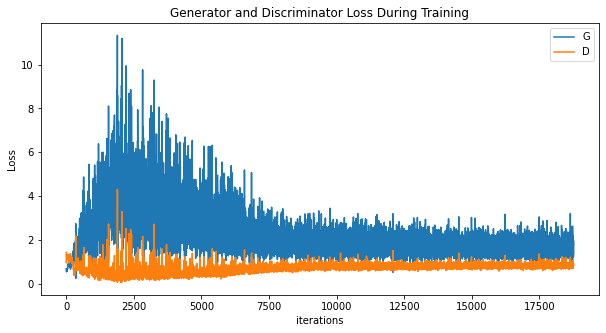

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()